## Analyzing the MTA Subway and Weather Data

#####Chris Daly
######06/08/2015

<img src="images/turnstile.png"> 

<br>

### Overview and Goals

_"The Metropolitan Transportation Authority is North America's largest transportation network, serving a population of 15.2 million people in the 5,000-square-mile area fanning out from New York City. It drives the New York regional economy by opening up countless job opportunities for millions – jobs that are miles from home are easy to get to with our subways, buses, and commuter trains. And after work, the network enables them to get to leisure activities: music, theater, cultural events, sports, and shopping more varied than anywhere in the USA."_ 

<br>

In this project I will analyze a sample of the MTA New York City Subway data from May 2015. This dataset contains hourly entries and exits for every turnstile in the subway system. In tandem with this I will also take a look at the weather in New York for the same period, taken from weather underground. Both of these datasets were prepared in separate notebooks and available in my github repository (https://github.com/chrisdaly/NYC-Subway-Weather-Analysis) if you would like to see how I scraped and cleaned them.

<br>

After exploring and analyzing the data I hope to be able to answer the following questions about the NYC subway traffic:

<br>


**What are the peak traffic times?** 

<br>
**Are weekdays busier than weekends?** 

<br> 
**Can big events be detected based on traffic?** 

<br>
**Which stations are the busiest? **  

<br>
**How does rain impact the NYC Subway Traffic?** 

#### Libraries Used

In [27]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import seaborn as sns
from sets import Set

%matplotlib inline
pd.options.display.mpl_style = 'default'
sns.set(style="whitegrid")

In [28]:
# CSS taken from http://nbviewer.ipython.org/gist/jackparmer/8d7e979bc4cec23db057
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())

#### Loading the Data

The data gathering process is detailed in the other two notebooks.

In [29]:
df_weather = pd.read_csv('data/final/weather_final.csv')
df_weather['DATE-TIME'] = pd.to_datetime(df_weather['DATE-TIME'])
df_weather['DATE'] = pd.to_datetime(df_weather['DATE-TIME']).apply(lambda x: x.date())
df_weather['TIME'] = pd.to_datetime(df_weather['DATE-TIME']).apply(lambda x: x.time())
df_weather.head(2)

,conds,dewptm,fog,hail,heatindexm,hum,precipm,pressurem,rain,snow,...,wdird,wgustm,windchillm,wspdm,time_n,date_n,WEEKDAY,DATE-TIME,DATE,TIME
0,Clear,15,0,0,-9999,64,-9999,1014.0,0,0,...,260,-9999,-999,24.1,00:53:00,2015-05-01,4,2015-05-01 00:53:00,2015-05-01,00:53:00
1,Clear,15,0,0,-9999,64,-9999,1013.6,0,0,...,270,-9999,-999,29.6,01:53:00,2015-05-01,4,2015-05-01 01:53:00,2015-05-01,01:53:00


In [30]:
df_turnstile = pd.read_csv('data/final/turnstile_final.csv')
df_turnstile['DATE-TIME'] = pd.to_datetime(df_turnstile['DATE-TIME'])
df_turnstile['DATE'] = pd.to_datetime(df_turnstile['DATE-TIME']).apply(lambda x: x.date())
df_turnstile['TIME'] = pd.to_datetime(df_turnstile['DATE-TIME']).apply(lambda x: x.time())
df_turnstile.head(1)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESCn,ENTRIES,EXITS,DATE-TIME,HOURLY_ENTRIES,HOURLY_EXITS,WEEKDAY,DAY_OF_WEEK
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,2015-05-01,00:00:00,REGULAR,5115461,1732389,2015-05-01,0,0,Friday,4


I thought about combining the two datasets in order to have everything in one place but it didn't seem very practical. The weather data is updated per hour while the turnstile data is updated every four hours. This desynch would either make the process of combining very tedious, or else bloat the data. 

So as a result I think I will mainly be using the weather data as a lookup table to find interesting times/dates and then check the corresponding times in the turnstile data.

### Exploratory Data Analysis

#### Weather Data

Firstly, the data was looked at in terms of days and dates. I was careful to note that some days will be occuring more than others, which will be important when looking at data on a per day or weekend vs weekday basis. In python's datetime module 0 represents a Monday.

In [31]:
df_weather.groupby(['WEEKDAY', 'date_n']).count().head(5)

conds  dewptm  fog  hail  heatindexm  hum  precipm  \
WEEKDAY date_n                                                           
0       2015-05-04     24      24   24    24          24   24       24   
        2015-05-11     27      27   27    27          27   27       27   
        2015-05-18     39      39   39    39          39   39       39   
        2015-05-25     44      44   44    44          44   44       44   
1       2015-05-05     27      27   27    27          27   27       27   

                    pressurem  rain  snow  ...   tornado  vism  wdird  wgustm  \
WEEKDAY date_n                             ...                                  
0       2015-05-04         24    24    24  ...        24    24     24      24   
        2015-05-11         27    27    27  ...        27    27     27      27   
        2015-05-18         39    39    39  ...        39    39     39      39   
        2015-05-25         44    44    44  ...        44    44     44      44   
1       2015-05-05         27    27    27  ...        27    27     27      27   

                    windchillm  wspdm  time_n  DATE-TIME  DATE  TIME  
WEEKDAY date_n                                                        
0       2015-05-04          24     24      24         24    24    24  
        2015-05-11          27     27      27         27    27    27  
        2015-05-18          39     39      39         39    39    39  
        2015-05-25          44     44      44         44    44    44  
1       2015-05-05          27     27      27         27    27    27  

[5 rows x 22 columns]

The breakdown is:

| Day        | Number of Days          | 
| ------------- |:-------------:| 
| Monday     | 4 | 
| Tuesday     | 4 | 
| Wednesday     | 4 | 
| Thursday     | 4 | 
| Friday     | 5 | 
| Saturday     | 5 | 
| Sunday     | 5 | 


##### Unexpected Rows

On further inspection of the above table, I noticed that quite a lot of days had more than the 24 observations I expected. I checked the wunderground site again and found this bit of information. 

<br>

*"Almost 2,000 Automated Surface Observation System (ASOS) stations located at airports throughout the country. These are maintained by the Federal Aviation Administration and observations are updated hourly, or more frequently when adverse weather affecting aviation occurs (low visibility, precipitation, etc)."* 

<br>

My first reaction was to simply remove these observations since the desynch between turnstile and weather datasets is already troublesome. The irregularity of the time series and extra rows may make plotting the data and doing computations may add to that. But these rows may also be the most important thing in the entire dataset - adverse weather that affects aviation may strongly correlate with that which changes subway traffic behaviour. 

<br>

I decided to pick a few rows from the first day the irregularity occurs. After doing this I found that the regular rows before and after the irregular row adequetely cover the change in weather conditions.

In [32]:
def get_relevant_times(df, type_, number):
    """
    
    Returns indices of interest for analyzing irregular times.
    
    """
    # Series of each observation's minute/second.
    if type_ == "second":
        filter = pd.Series([n.second for n in df['DATE-TIME']])
        
    elif type_ == "minute":
        filter = pd.Series([n.minute for n in df['DATE-TIME']])    
    
    # Find the irregular intervals.
    irreg_rows = df.loc[filter != number]
    
    return irreg_rows.index.values

In [33]:
# Get irregular times, i.e. not on the 53rd minute.
irreg_times = get_relevant_times(df_weather, 'minute', 53)

In [34]:
df_weather = df_weather.drop(irreg_times)

In [35]:
df_weather.groupby(['WEEKDAY', 'date_n']).count().head(3)

conds  dewptm  fog  hail  heatindexm  hum  precipm  \
WEEKDAY date_n                                                           
0       2015-05-04     24      24   24    24          24   24       24   
        2015-05-11     24      24   24    24          24   24       24   
        2015-05-18     24      24   24    24          24   24       24   

                    pressurem  rain  snow  ...   tornado  vism  wdird  wgustm  \
WEEKDAY date_n                             ...                                  
0       2015-05-04         24    24    24  ...        24    24     24      24   
        2015-05-11         24    24    24  ...        24    24     24      24   
        2015-05-18         24    24    24  ...        24    24     24      24   

                    windchillm  wspdm  time_n  DATE-TIME  DATE  TIME  
WEEKDAY date_n                                                        
0       2015-05-04          24     24      24         24    24    24  
        2015-05-11          24     24      24         24    24    24  
        2015-05-18          24     24      24         24    24    24  

[3 rows x 22 columns]

Now every day has 24 entries.

### Subway Data

#### Further Preparation

When I was preparing the subway data I did it in a manner to preserve as much relevant data as possible. Now I'm going to distill it down into the most important parts.  

<br>

Firstly the 3 identifier columns can be confusing at first and are awkward for lookups so I will combine them into a TURNSTILE column.

In [36]:
df_turnstile['TURNSTILE'] = (df_turnstile['C/A'].map(str)) + " " + (df_turnstile['UNIT'].map(str)) + " " +  (df_turnstile['SCP'].map(str))

#### Entries vs Exits

In [37]:
top_stations = df_turnstile.groupby('STATION').sum().sort('HOURLY_ENTRIES', ascending=False)
top_stations.head(5)

,ENTRIES,EXITS,HOURLY_ENTRIES,HOURLY_EXITS,DAY_OF_WEEK
STATION,,,,,
34 ST-PENN STA,487488367433,170792980369,4555680,3943564,59363
42 ST-GRD CNTRL,530049533902,140240261792,3790231,3537106,36765
34 ST-HERALD SQ,80182896378,60720476090,3181554,2886184,31484
86 ST,261677754150,124970313558,3011844,2428819,30778
14 ST-UNION SQ,240653963801,92601454461,2977231,2686683,22524


In [38]:
weekday = df_turnstile.groupby('WEEKDAY').sum().sort('DAY_OF_WEEK', ascending=True).reset_index()
weekday

,WEEKDAY,ENTRIES,EXITS,HOURLY_ENTRIES,HOURLY_EXITS,DAY_OF_WEEK
0,Monday,2226306479674,1600181724439,19428124,14572178,0
1,Tuesday,2217388559344,1583300106696,23026236,17194866,99962
2,Wednesday,2209873532902,1573120477531,23637115,17705607,199852
3,Thursday,2212232946600,1582016555992,23613659,17651859,299382
4,Friday,2773241764264,1985255034841,28504698,21303248,497756
5,Saturday,2922132941472,2135758299419,15289258,12059412,626455
6,Sunday,2800702856276,2017936877052,14175402,11379132,750714


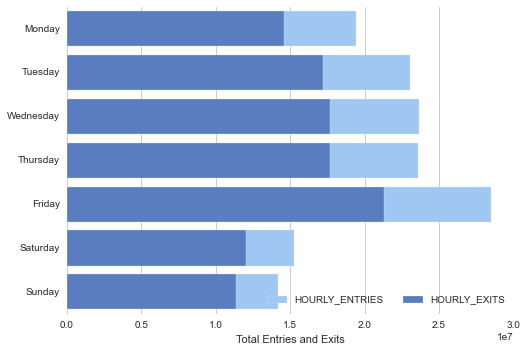

In [39]:
# Initialize the matplotlib figure.
f, ax = plt.subplots()

# Plot the Entries.
sns.set_color_codes("pastel")
sns.barplot(x="HOURLY_ENTRIES", y="WEEKDAY", data=weekday,
            label="HOURLY_ENTRIES", color="b")

# Plot the Exits.
sns.set_color_codes("muted")
sns.barplot(x="HOURLY_EXITS", y="WEEKDAY", data=weekday,
            label="HOURLY_EXITS", color="b")

ax.legend(ncol=2, loc="lower right", frameon=False)
ax.set(ylabel="",
       xlabel="Total Entries and Exits")
sns.despine(left=True, bottom=True)

In [40]:
# Get total number of entries - exits.
print df_turnstile['HOURLY_ENTRIES'].sum(), df_turnstile['HOURLY_EXITS'].sum()
print (df_turnstile['HOURLY_ENTRIES'].sum() - df_turnstile['HOURLY_EXITS'].sum())/(df_turnstile['HOURLY_ENTRIES'].sum()) * 100

147674492.0 111866302.0
24.2480536178


In a perfect world you would expect the total number of entries to be equal to the total amount of exits. However plenty of people exit through emergency doors, especially at stations which have only a few turnstiles. Out of the total number of turnstile entries for May 2015, 24% do not have corresponding exits. Entries is a more accurate parameter and it's what I will be focusing on for this analysis. 

<br>

<img src="images/exits.jpg">

#### Dropping Columns

In [41]:
df_turnstile = df_turnstile.drop(['ENTRIES', 'EXITS', 'C/A', 'UNIT', 'SCP'], axis=1)

#### Unexpected Rows

Similar to the weather dataset, the turnstiles also have extra observations. These are due to maintenance and no useful information is taken from them. 

In [42]:
irreg_times = get_relevant_times(df_turnstile, "second", 00)
df_turnstile = df_turnstile.drop(irreg_times)

In [43]:
df_turnstile.groupby(['WEEKDAY', 'DATE', 'TURNSTILE']).count().head(3)

STATION  LINENAME  DIVISION  TIME  \
WEEKDAY DATE       TURNSTILE                                               
Friday  2015-05-01 A002 R051 02-00-00        6         6         6     6   
                   A002 R051 02-00-01        6         6         6     6   
                   A002 R051 02-03-00        6         6         6     6   

                                       DESCn  DATE-TIME  HOURLY_ENTRIES  \
WEEKDAY DATE       TURNSTILE                                              
Friday  2015-05-01 A002 R051 02-00-00      6          6               6   
                   A002 R051 02-00-01      6          6               6   
                   A002 R051 02-03-00      6          6               6   

                                       HOURLY_EXITS  DAY_OF_WEEK  
WEEKDAY DATE       TURNSTILE                                      
Friday  2015-05-01 A002 R051 02-00-00             6            6  
                   A002 R051 02-00-01             6            6  
                   A002 R051 02-03-00             6            6

Every turnstile now has 6 entries per day as expected.

##### Total Ridership

In [44]:
total_entries = pd.DataFrame(df_turnstile.groupby(['WEEKDAY', 'DAY_OF_WEEK'])[['HOURLY_ENTRIES']].sum()).reset_index()
total_entries = total_entries.sort('DAY_OF_WEEK')
total_entries

,WEEKDAY,DAY_OF_WEEK,HOURLY_ENTRIES
1,Monday,0,19376184
5,Tuesday,1,22968037
6,Wednesday,2,23568312
4,Thursday,3,23561747
0,Friday,4,28448498
2,Saturday,5,15268389
3,Sunday,6,14137369


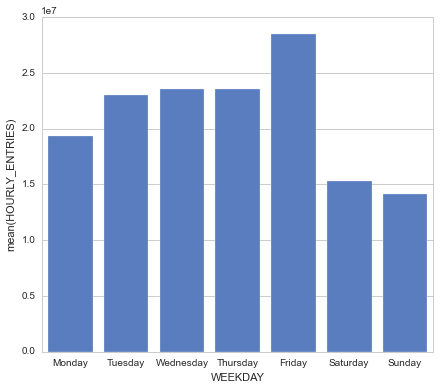

In [45]:
# Initialize the matplotlib figure.
f, ax = plt.subplots(figsize=(7, 6))

sns.set_color_codes("muted")
sns.barplot(x="WEEKDAY", y="HOURLY_ENTRIES", 
            data=total_entries,
            color="b")

##### Average Ridership

In [46]:
average_entries = pd.DataFrame(df_turnstile.groupby(['WEEKDAY', 'DAY_OF_WEEK'])[['HOURLY_ENTRIES']].mean()).reset_index()
average_entries = average_entries.sort('DAY_OF_WEEK')
average_entries

,WEEKDAY,DAY_OF_WEEK,HOURLY_ENTRIES
1,Monday,0,193.785094
5,Tuesday,1,230.020801
6,Wednesday,2,236.188564
4,Thursday,3,236.338302
0,Friday,4,228.854925
2,Saturday,5,121.998762
3,Sunday,6,113.107096


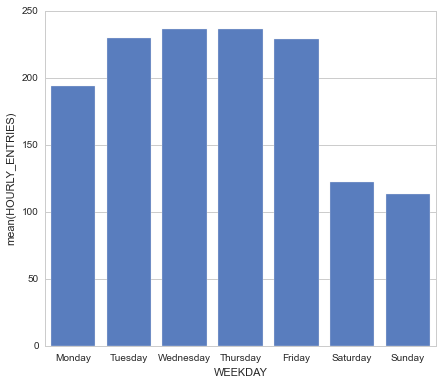

In [47]:
# Initialize the matplotlib figure.
f, ax = plt.subplots(figsize=(7, 6))

sns.set_color_codes("muted")

sns.barplot(x="WEEKDAY", y="HOURLY_ENTRIES", 
            data=average_entries,
            color="b")

##### Ridership Throughout the Day

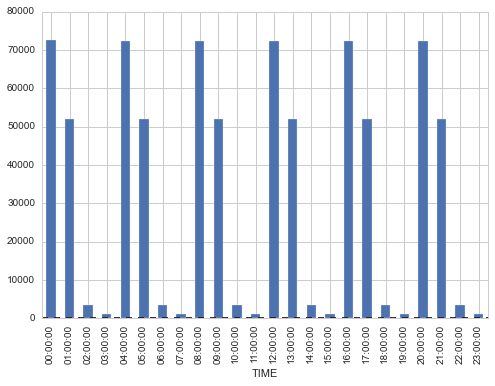

In [48]:
# How well each hour is represented.
df_turnstile.groupby('TIME')['HOURLY_ENTRIES'].count().plot(kind='bar')

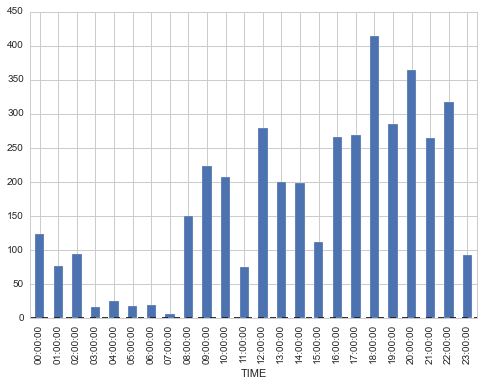

In [49]:
# Average ridership per hour.
df_turnstile.groupby('TIME')['HOURLY_ENTRIES'].mean().plot(kind='bar')

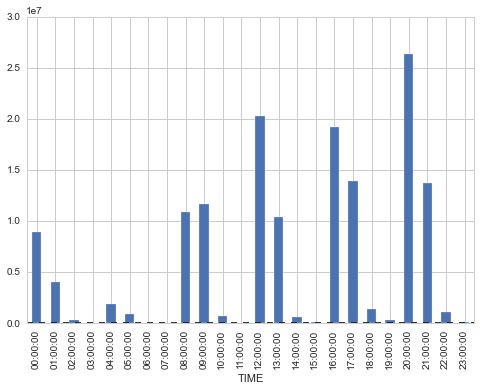

In [50]:
# Total ridership per hour.
df_turnstile.groupby('TIME')['HOURLY_ENTRIES'].sum().plot(kind='bar')

The above graphs reflect the unfortunate deficiences of the data - it isn't collected hourly. Addtionally, some turnstiles just start at 1am instead of midnight arbitrarily. As a result there isn't an equal number of observations so that even though I'm taking the mean of each hour, it's an unbalanced represenation.
 

<br>

In order to get a better view I'll divide the day into six 4 hour segments.

In [51]:
i_1 = df_turnstile[(df_turnstile['TIME'] >= datetime.time(0, 0)) & (df_turnstile['TIME'] < datetime.time(4, 0))].index
i_2 = df_turnstile[(df_turnstile['TIME'] >= datetime.time(4, 0)) & (df_turnstile['TIME'] < datetime.time(8, 0))].index
i_3 = df_turnstile[(df_turnstile['TIME'] >= datetime.time(8, 0)) & (df_turnstile['TIME'] < datetime.time(12, 0))].index
i_4 = df_turnstile[(df_turnstile['TIME'] >= datetime.time(12, 0)) & (df_turnstile['TIME'] < datetime.time(16, 0))].index
i_5 = df_turnstile[(df_turnstile['TIME'] >= datetime.time(16, 0)) & (df_turnstile['TIME'] < datetime.time(20, 0))].index
i_6 = df_turnstile[(df_turnstile['TIME'] >= datetime.time(20, 0))].index

In [52]:
# Supress copy warning.
pd.options.mode.chained_assignment = None

# Set the time preiod based on the time.
df_turnstile['PERIOD'] = 0
df_turnstile['PERIOD'][i_1] = datetime.time(0, 0)
df_turnstile['PERIOD'][i_2] = datetime.time(4, 0)
df_turnstile['PERIOD'][i_3] = datetime.time(8, 0)
df_turnstile['PERIOD'][i_4] = datetime.time(12, 0)
df_turnstile['PERIOD'][i_5] = datetime.time(16, 0)
df_turnstile['PERIOD'][i_6] = datetime.time(20, 0)

In [53]:
#a = df_turnstile.groupby('PERIOD')['HOURLY_ENTRIES'].count()
#a = a.reset_index()

#sns.set_color_codes("muted")

#sns.barplot(x="PERIOD", y="HOURLY_ENTRIES", data=a, color="b")

#sns.despine(offset=0, trim=True)

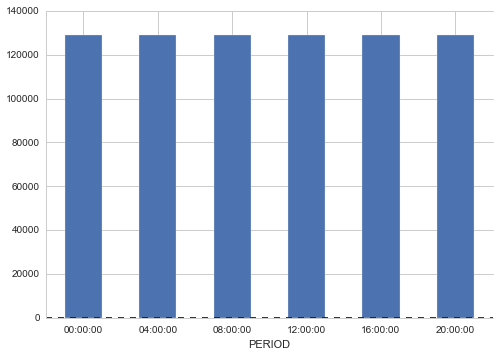

In [54]:
# How well each time period is represented.
df_turnstile.groupby('PERIOD')['HOURLY_ENTRIES'].count().plot(kind='bar')
sns.despine(offset=0, trim=True)

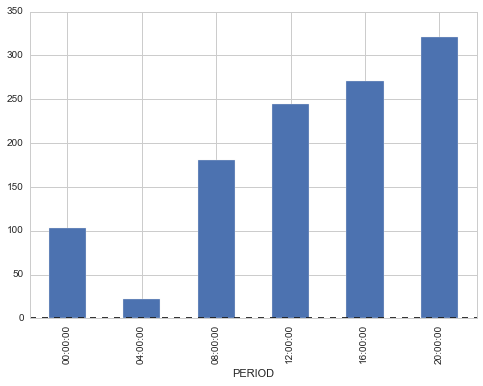

In [55]:
# Average ridership per time period.
df_turnstile.groupby('PERIOD')['HOURLY_ENTRIES'].mean().plot(kind='bar')
#sns.despine(offset=0, trim=True)

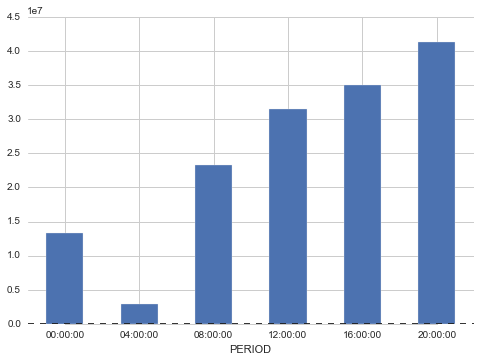

In [56]:
# Total ridership per time period.
df_turnstile.groupby('PERIOD')['HOURLY_ENTRIES'].sum().plot(kind='bar')
sns.despine(offset=0, trim=True, left=True)

The most popular time period is from 8pm to midnight and the least popular is 4am to 8am.

##### Weekend vs Weekday

In [57]:
average_entries

,WEEKDAY,DAY_OF_WEEK,HOURLY_ENTRIES
1,Monday,0,193.785094
5,Tuesday,1,230.020801
6,Wednesday,2,236.188564
4,Thursday,3,236.338302
0,Friday,4,228.854925
2,Saturday,5,121.998762
3,Sunday,6,113.107096


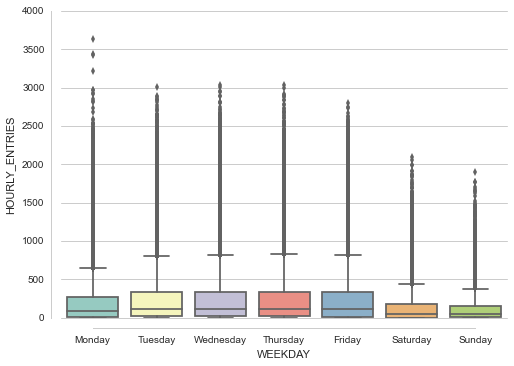

In [58]:
sns.boxplot(x="WEEKDAY", y="HOURLY_ENTRIES", data=df_turnstile.sort('DAY_OF_WEEK'), palette="Set3")
sns.despine(offset=10, trim=True)

As expected, the weekends have a much lower ridership than the weekdays. Each day experiences extreme outliers due to rushours.

<br>
Interestingly Monday has the smallest average value but the highest peak values. To understand this trend more, I'll plot graphs for each day throughout the month.

##### Big Events

WEEKDAY
Friday       Axes(0.125,0.125;0.775x0.775)
Monday       Axes(0.125,0.125;0.775x0.775)
Saturday     Axes(0.125,0.125;0.775x0.775)
Sunday       Axes(0.125,0.125;0.775x0.775)
Thursday     Axes(0.125,0.125;0.775x0.775)
Tuesday      Axes(0.125,0.125;0.775x0.775)
Wednesday    Axes(0.125,0.125;0.775x0.775)
dtype: object

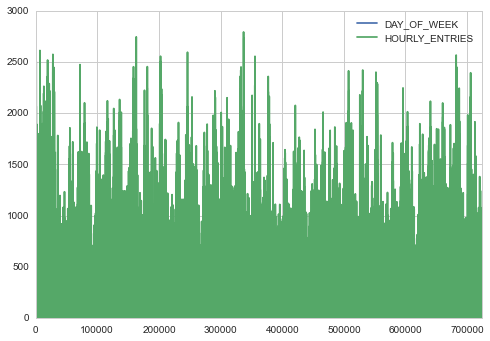

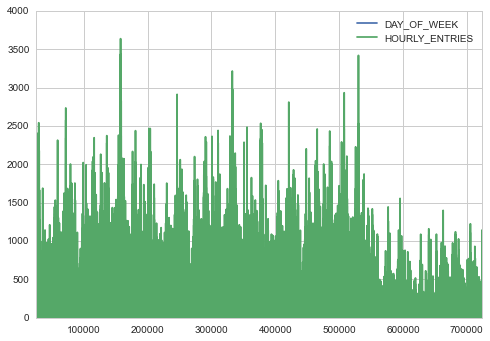

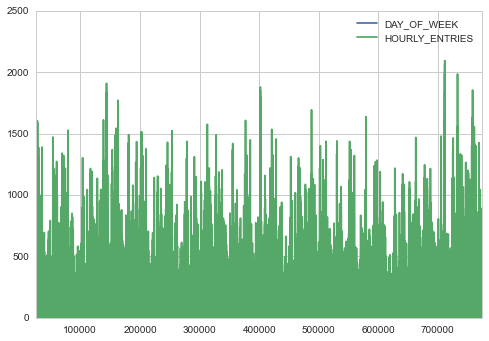

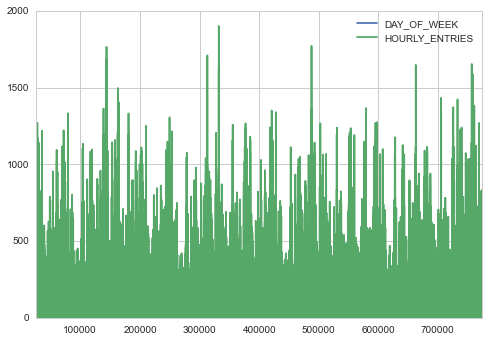

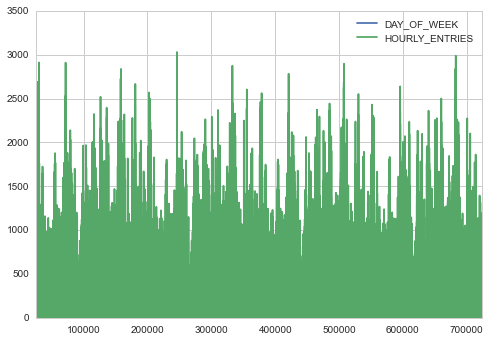

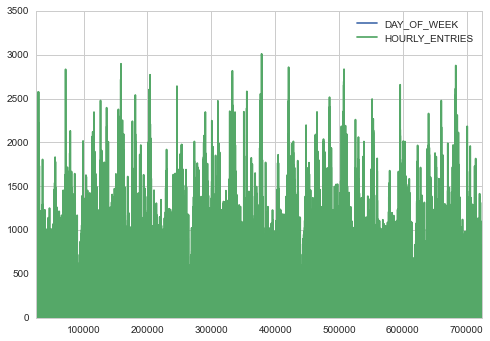

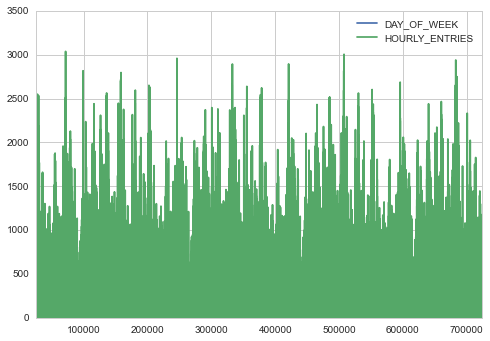

In [59]:
df_turnstile.drop('HOURLY_EXITS', axis=1).groupby('WEEKDAY').plot()

In the above set of graphs, the 2nd one (Monday) has a big sudden decrease in entries and exits for the last Monday of the month. This corresponds to 25/05/2015 which is memorial day which explains the difference between Monday and the rest of the weekdays. 

<br>

<img src="images/memorial.jpg">

##### Top Stations and Turnstiles

In [60]:
top_stations = df_turnstile.groupby('STATION').sum().sort('HOURLY_ENTRIES', ascending=False)
top_stations.head(5)

,HOURLY_ENTRIES,HOURLY_EXITS,DAY_OF_WEEK
STATION,,,
34 ST-PENN STA,4555680,3943564,59363
42 ST-GRD CNTRL,3790231,3537106,36765
34 ST-HERALD SQ,3181554,2886184,31484
86 ST,3011844,2428819,30778
14 ST-UNION SQ,2977231,2686683,22524


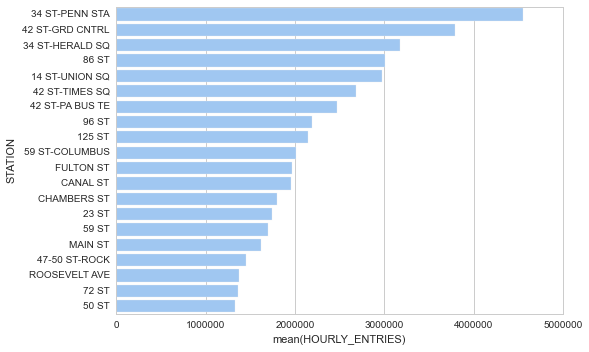

In [61]:
sns.set_color_codes("pastel")

sns.barplot(x="HOURLY_ENTRIES", y="STATION", 
            data=pd.DataFrame(top_stations[0:20]['HOURLY_ENTRIES']).reset_index(),
            color="b")

In [62]:
top_turnstiles = df_turnstile.groupby(['STATION', 'TURNSTILE']).sum().sort('HOURLY_ENTRIES', ascending=False)
top_turnstiles.head(5)

HOURLY_ENTRIES  HOURLY_EXITS  DAY_OF_WEEK
STATION        TURNSTILE                                                    
59 ST-COLUMBUS N051 R084 02-00-00          199860         24557          594
JAMAICA CENTER N606 R025 00-00-07          197060         27919          594
               N606 R025 00-00-08          185901         19077          594
GRAND-30 AVE   R513 R093 00-03-00          181583         11434          594
42 ST-TIMES SQ R151 R033 00-00-01          177624         34415          594

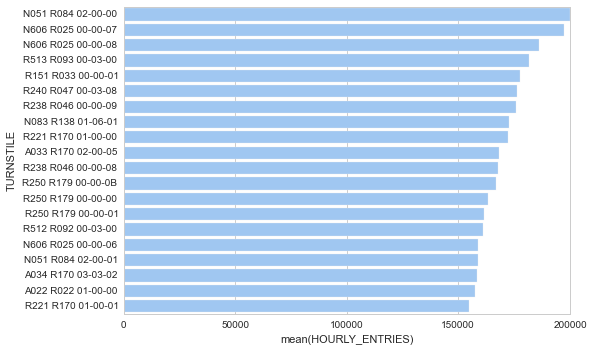

In [63]:
sns.set_color_codes("pastel")

sns.barplot(x="HOURLY_ENTRIES", y="TURNSTILE", 
            data=pd.DataFrame(top_turnstiles)[0:20].reset_index(),
            color="b")

34th Street Penn Station is by far the most popular station. Interestingly, none of the top stations have the most used turnstiles. This is probably because these stations are adequetly equiped with many turnstiles to balance the load, whereas smaller stations have less turnstiles that are heavily used. 

<br>

<img src="images/penn.jpg">

In [64]:
top_turnstiles[-10:]['HOURLY_ENTRIES']

STATION          TURNSTILE          
COURT SQ         N400A R359 02-06-06    0
DYCKMAN ST       R186 R036 00-05-01     0
SUTPHIN BLVD     N338 R128 01-05-01     0
STILLWELL AVE    G009 R151 02-05-01     0
COURT SQ         R508 R346 00-05-01     0
CROWN HTS-UTICA  R626 R062 00-05-01     0
DEKALB AVE       C008 R099 00-04-01     0
DITMAS AVE       N547 R420 01-04-01     0
STILLWELL AVE    G001 R151 00-05-01     0
ZEREGA AVE       R419 R326 00-05-01     0
Name: HOURLY_ENTRIES, dtype: float64

In [65]:
turnstiles_total = top_turnstiles['HOURLY_ENTRIES'].count()
turnstiles_not_working = top_turnstiles[top_turnstiles['HOURLY_ENTRIES'] == 0]['HOURLY_ENTRIES'].count()
100*(turnstiles_total-turnstiles_not_working)/(turnstiles_total)

94

On the other hand, the most underutilized turnstiles haven't had a single entry for the whole month. These represent ~6% of the total number of turnstiles. These turnstiles are most likely broken.

##### Rainy Days

In [66]:
# Get the rainy days.
rain_filter = df_weather['rain'] == 1

day_rain = df_weather[rain_filter]['DATE']
day_rain = day_rain.unique()
day_rain

array([datetime.date(2015, 5, 4), datetime.date(2015, 5, 6),
       datetime.date(2015, 5, 11), datetime.date(2015, 5, 12),
       datetime.date(2015, 5, 15), datetime.date(2015, 5, 16),
       datetime.date(2015, 5, 18), datetime.date(2015, 5, 21),
       datetime.date(2015, 5, 24), datetime.date(2015, 5, 25),
       datetime.date(2015, 5, 26), datetime.date(2015, 5, 27),
       datetime.date(2015, 5, 31)], dtype=object)

In [67]:
number_rain_days = len(day_rain)
number_days = len(df_turnstile.DATE.unique())

100 * (number_rain_days)/float(number_days)

41.935483870967744

In [68]:
[day_rain[n].weekday() for n in range(len(day_rain))]

[0, 2, 0, 1, 4, 5, 0, 3, 6, 0, 1, 2, 6]

It rained in about 42% of the days in May and there are also 4 dates that are on the weekend. This is a pretty good spread and I won't need to normalize to get an initial indicator. Unfortunately all of the Mondays are rainy days.

In [69]:
# Create a RAIN column for the DF.
df_turnstile['RAIN'] = df_turnstile['DATE'].apply(lambda x: x in day_rain)

In [70]:
norain_stats = df_turnstile[df_turnstile['RAIN'] == 0].groupby(['WEEKDAY'])['HOURLY_ENTRIES'].mean()
rain_stats = df_turnstile[df_turnstile['RAIN'] == 1].groupby(['WEEKDAY'])['HOURLY_ENTRIES'].mean()

print "NO RAIN STATISTICS\n{}".format(norain_stats)

print "\nRAIN STATISTICS\n{}".format(rain_stats)
print "\nDIFFERENCE\n{}".format(norain_stats - rain_stats)
print "\nTOTAL DIFFERENCE\n{}".format((norain_stats - rain_stats).sum())

NO RAIN STATISTICS
WEEKDAY
Friday       226.596810
Saturday     122.935624
Sunday       113.990085
Thursday     235.886590
Tuesday      232.899381
Wednesday    239.228452
Name: HOURLY_ENTRIES, dtype: float64

RAIN STATISTICS
WEEKDAY
Friday       237.855052
Monday       193.785094
Saturday     118.246741
Sunday       111.785108
Thursday     237.692912
Tuesday      227.143950
Wednesday    233.151963
Name: HOURLY_ENTRIES, dtype: float64

DIFFERENCE
WEEKDAY
Friday      -11.258241
Monday             NaN
Saturday      4.688883
Sunday        2.204977
Thursday     -1.806323
Tuesday       5.755431
Wednesday     6.076489
Name: HOURLY_ENTRIES, dtype: float64

TOTAL DIFFERENCE
5.66121659526


The above tables show that on average the hourly entries on non-rainy days is ~5.7 higher than on rainy days. This goes against my intuition and it may also be a bad way of looking at the problem. As shown in previous graphs, the turnstiles undergo massive spikes in traffic during rush hour so this is a relatively low figure. A better way to analyze the difference would be on a smaller interval.

In [71]:
# Subset rain and no rain.
rain = df_turnstile[df_turnstile.RAIN == 0]['HOURLY_ENTRIES']
no_rain = df_turnstile[df_turnstile.RAIN == 1]['HOURLY_ENTRIES']

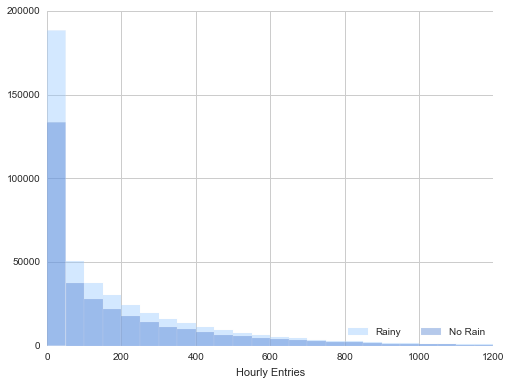

In [72]:
# Set up the bins.
num_bins = 40
start_bin = min(df_turnstile['HOURLY_ENTRIES'])
stop_bin = 2000 # max(turnstile_master['ENTRIESn_hourly'])
bin_width = (stop_bin - start_bin)/num_bins
bin_list = np.arange(start_bin, stop_bin, bin_width)

# Initialize the matplotlib figure.
f, ax = plt.subplots(figsize=(8, 6))
sns.set_color_codes("pastel")

# Histogram for rainy days.
sns.set_color_codes("pastel")
sns.distplot(rain, kde=False, label="Rainy", color="b", bins=bin_list)

# Histogram for non-rainy days.
sns.set_color_codes("muted")
sns.distplot(no_rain, kde=False, label="No Rain", color="b", bins=bin_list)

# Set text fields.
ax.legend(ncol=2, loc="lower right", frameon=False)
ax.set(xlim=(0, 1200), ylabel="",
       xlabel="Hourly Entries")
sns.despine(left=True, bottom=True)

The above graph shows that there are more hourly entries for almost the whole day when it's raining. However, when the entries are at their maximum (i.e. rush hour) there are slightly less people using the subway when it is raining. 

<br>

<img src="images/rainy.jpg">

### Statistical Test

I then analyzed the data with the Mann-Whitney U-Test. A two-tail p-value was used as no prior assumptions are made about the contrast in the distributions of ridership on rainy and non-rainy days. The p-value returned by scipy.stats.mannwhitneyu is one-tailed as noted here:
http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html. 
 

<br>

In order to use a two-tailed test, the one-tailed p-value returned by scipy.stats.mannwhitneyu must be multiplied by 2. 

<br>

The significance level being used in this test is 0.05 (i.e. 5% chance of observing a result as least as extreme).

\begin{align*}
   H_0 & : Response\ and\ explanatory\ variable\ are\ independent
   \\
   H_a & :Response\ and\ explanatory\ variable\ are\ dependent
\end{align*}

In [73]:
rain_mean = np.mean(df_turnstile[df_turnstile.RAIN == 1]['HOURLY_ENTRIES'])
norain_mean = np.mean(df_turnstile[df_turnstile.RAIN == 0]['HOURLY_ENTRIES'])

print "Mean entries, with rain: {0}\nMean entries, without rain: {1}".format(rain_mean, norain_mean)

Mean entries, with rain: 193.265878832
Mean entries, without rain: 188.332271715


In [74]:
[U, p] = scipy.stats.mannwhitneyu(df_turnstile[df_turnstile.RAIN == 1]['HOURLY_ENTRIES'],
                                  df_turnstile[df_turnstile.RAIN == 0]['HOURLY_ENTRIES'])

print "Mann-Whitney Test Statistic: {0}\np-Value: {1}".format(U, p)

Mann-Whitney Test Statistic: 71829972427.5
p-Value: 9.35343547837e-112


In [75]:
# Significance level.
alpha = 0.05

# Two-tailed test.
if (p * 2) < alpha:
    print 'Reject the null hypothesis'
else:
    print 'Fail to reject null hypothesis'

Reject the null hypothesis


### Conclusion

My findings suggest that rain does indeed affect the subway traffic and it does so in two ways. 

<br>

The first is that it increases almost all of the traffic throughout the day. This seems very reasonable. If a person intends to travel a short journey by walking or biking, then it starts raining, and suddenly the subway becomes a much more attractive option. 

<br>

The second is that rain actually very slightly decreases the traffic during peak hours. I can understand this also, if a person doesn't absolutely need to use the subway at that time, the extra hassle caused by the rain may deter them from taking a crowded train.

### Recommendations

My main issue throughout the analysis was that the time duration I looked at was too big. I considered things in days rather than hours. In order to get the rainy days, I looked up the weather dataframe for days that experienced ANY rain and jotted them down as a rainy day. However, this method is flawed as these days may only have experienced an hour of rain and yet get grouped with a day that has rained for 24 hours. 

<br>

Ideally I would have been able to check what hours had rain and then check the subway data for that hour. However, the subway data only updates every four hours. I thought about imputing the missing hours from the subway data, or dropping the extra hours from the weather data, but I decided both were flawed and complicated approaches. The weather in New York can change rapidly and without hourly records available from the MTA website it's very difficult to get knowledge on how that affects the subway traffic. 

<br>

Another issue I had was manually converting the cumulative data to hourly data. I think this should be done automatically by the MTA or the turnstiles themselves. The function I used wasn't vectorized and took over 12 hours to convert the 800k records. 

<br>

Related to my previous two issues, is the time span I chose to look at is also too small. I only took one month and while patterns did appear, it wasn't overly convincing. I thought about redoing the analysis for a season or an entire year but the lack of hourly observations and the time needed to convert the values made the endeavour too costly for too little additional benefit.

### Future Work

Throughout this project I looked into similar works from other people to see how they approached the data and analysis. For me, the most impressive projects were ones that coupled great visualizations with insight. I highly recommend checking out Mike Barry and Brian Card's project on the Boston subway station at http://mbtaviz.github.io/. Once I improve my d3 skills I want to come back to this project and try to emmulate these visualizations.

###Links
    
http://web.mta.info/developers/index.html
<br>    
http://web.mta.info/developers/turnstile.html\n
<br>   
https://groups.google.com/forum/#!topic/mtadeveloperresources/hKQ_k9DwyEU

<br>
http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt 
   